# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)


import warnings
warnings.filterwarnings("ignore")

# EDA

### 1. portfolio dataset

In [2]:
portfolio.head(), portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


(   reward                      channels  difficulty  duration     offer_type  \
 0      10       [email, mobile, social]          10         7           bogo   
 1      10  [web, email, mobile, social]          10         5           bogo   
 2       0          [web, email, mobile]           0         4  informational   
 3       5          [web, email, mobile]           5         7           bogo   
 4       5                  [web, email]          20        10       discount   
 
                                  id  
 0  ae264e3637204a6fb9bb56bc8210ddfd  
 1  4d5c57ea9a6940dd891ad53e9dbe8da0  
 2  3f207df678b143eea3cee63160fa8bed  
 3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
 4  0b1e1539f2cc45b7b9fa7c272da2e1d7  ,
 None)

In [3]:
id_duplicates = portfolio['id'].duplicated().sum()
print('There is {} duplicates in offer id.'.format(id_duplicates))

There is 0 duplicates in offer id.


In [4]:
# rename id to offer_id
portfolio.rename(columns={'id':'offer_id'}, inplace=True)

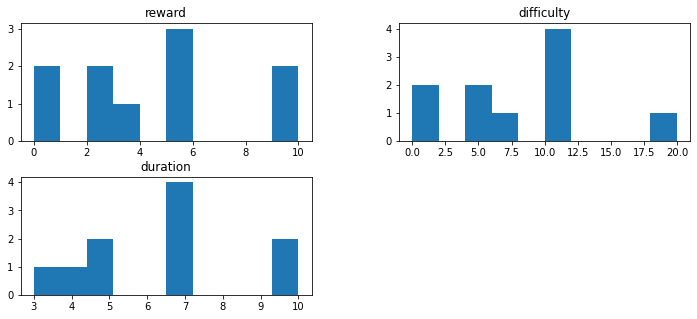

In [5]:
portfolio.hist(figsize=(12,5), grid=False);

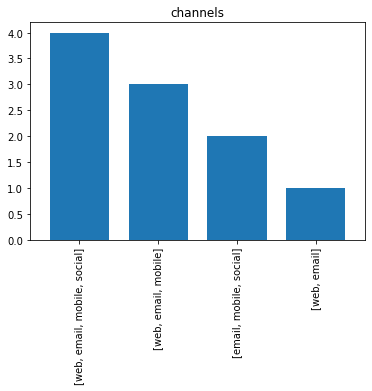

In [6]:
portfolio['channels'].value_counts().plot(kind='bar', title='channels', width=0.75);

Most of offers are sending on all channels.

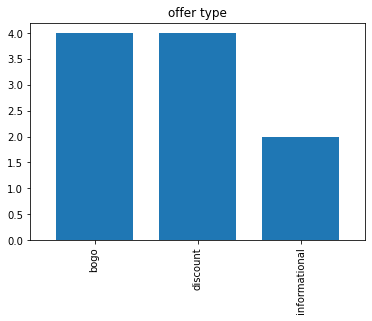

In [7]:
portfolio['offer_type'].value_counts().plot(kind='bar', title='offer type', width=0.75);

In [8]:
# clean channel
channels = pd.get_dummies(portfolio['channels'].apply(pd.Series).stack()).sum(level=0)
portfolio_new = portfolio.merge(channels, left_index=True, right_index=True)
portfolio_new = portfolio_new.drop('channels', axis=1)

In [9]:
# clean offer_type
offer_type = pd.get_dummies(portfolio_new['offer_type'])
portfolio_new.merge(offer_type, left_index=True, right_index=True)
portfolio_new = portfolio_new.drop('offer_type', axis=1)

### 2. profile dataset

In [10]:
profile.head(), profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


(  gender  age                                id  became_member_on    income
 0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
 1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
 2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
 3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
 4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN,
 None)

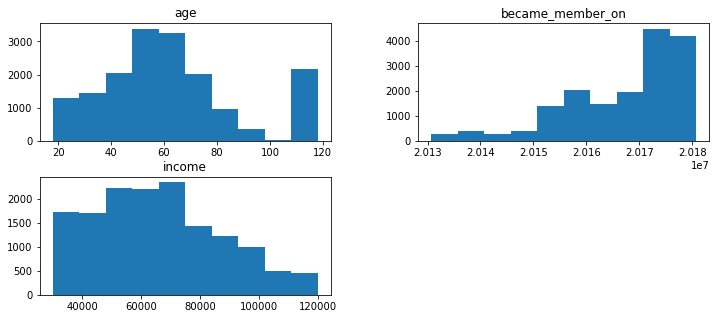

In [11]:
profile.hist(figsize=(12,5), grid=False);

In age distribution, there are some ages above 100, which doesn't seem to be correct.

In [12]:
# check and clean age over 100
profile[profile['age']>=100]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


In [13]:
# none values in age and income for ages over 100
profile[profile['age']>=100].isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [14]:
# ages over 100 have no values in gender and income, drop rows when ages are over 100
drop_age = profile[profile['age']>=100].index

profile = profile.drop(axis=0, index=drop_age)
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14808 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14808 non-null  object 
 1   age               14808 non-null  int64  
 2   id                14808 non-null  object 
 3   became_member_on  14808 non-null  int64  
 4   income            14808 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.1+ KB


In [15]:
# after dropping ages over 100, there are no values any more
profile.isnull().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

In [16]:
# no duplicates in customer id
profile['id'].duplicated().sum()

0

In [17]:
# rename id to customer_id
profile.rename(columns={'id':'customer_id'}, inplace=True)

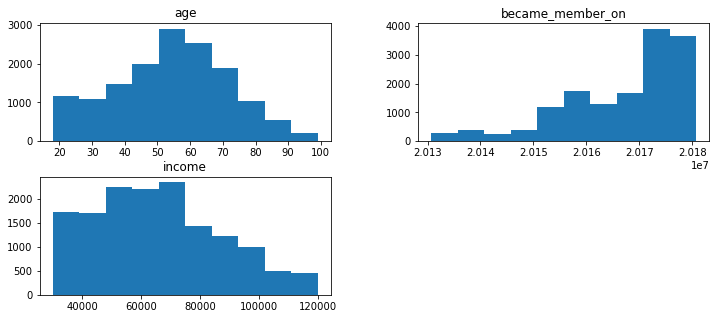

In [18]:
# distribution of numerical values seem better now
profile.hist(figsize=(12,5), grid=False);

- age is quite normal distribution, centralized at 50 to 60.
- became_member_on is left skewed, most customers (6500) became members in 2017 and 2018.
- income is right skewed, mode is at around 70000.

In [19]:
profile.describe()

,age,became_member_on,income
count,14808.000000,1.480800e+04,14808.000000
mean,54.340829,2.016689e+07,65394.313884
std,17.323921,1.188748e+04,21595.072904
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016052e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,99.000000,2.018073e+07,120000.000000


- Most customers sit in age group 50 to 60. Will use the 25%, 50% and 75% as a criteria to seperate customers into different age groups.

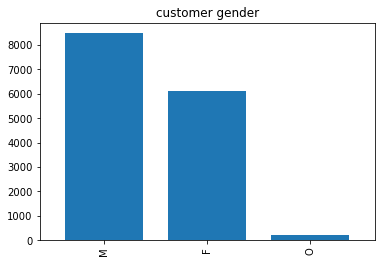

In [20]:
profile['gender'].value_counts().plot(kind='bar', title='customer gender', width=0.75);

In customer gender group, males (8000) are more than females (6000).

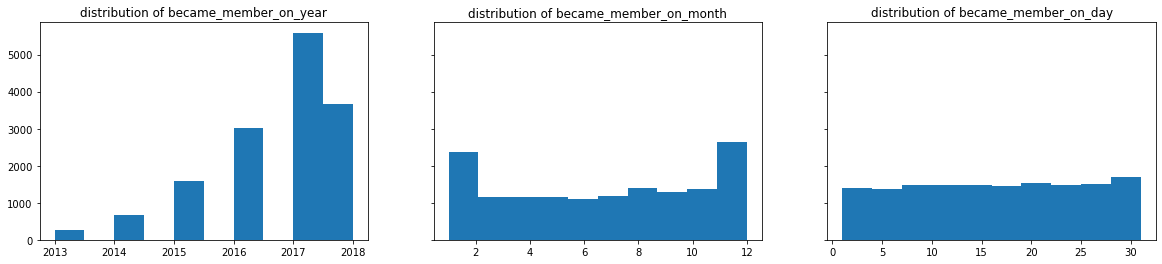

In [21]:
# seperate became_member_on value to year, month, day as single feature
profile['became_member_on_year'] = profile['became_member_on'].apply(lambda x: int(str(x)[:4]))
profile['became_member_on_month'] = profile['became_member_on'].apply(lambda x: int(str(x)[4:6]))
profile['became_member_on_day'] = profile['became_member_on'].apply(lambda x: int(str(x)[6:8]))

# plot to see pattern
fig, ax = plt.subplots(1, 3, figsize=(20,4), sharey=True)
ax[0].hist(profile['became_member_on_year'])
ax[0].set_title('distribution of became_member_on_year')

ax[1].hist(profile['became_member_on_month'])
ax[1].set_title('distribution of became_member_on_month')

ax[2].hist(profile['became_member_on_day'])
ax[2].set_title('distribution of became_member_on_day');

- Most customers became member in 2017 and 2018, in Jan to Mar.
- It seems the impact of year on number of customers are big, as well as month (Nov to Feb), however day as a feature has very small impact.

In [22]:
def profile_cleaning():
    """ Method to clean up profile dataset,
        it first encode gender,
        then split age group into bins,
        encode became_member_on,
        at last encode age group.
    
    Inputs: none
    Outputs: a cleaned new dataset, dataframe
    
    """
    # transform gender into dummy
    profile_gender = pd.get_dummies(profile['gender'])
    profile_new_df = profile_gender.merge(profile, left_on=profile.index, right_on=profile_gender.index)
    
    # drop old gender feature and the other extra
    profile_new_df = profile_new_df.drop(['gender','key_0'], axis=1)
    
    # split age into different groups
    perc_25 = profile['age'].describe()[4]
    perc_50 = profile['age'].describe()[5]
    perc_75 = profile['age'].describe()[6]
    perc_min = profile['age'].min()
    perc_max = profile['age'].max()
    
    # set bins and names
    bins_edge = [perc_min, perc_25, perc_50, perc_75, perc_max]
    bins_names = ['18_42', '42_55', '55_66', '66_99']
    
    # cut bins
    profile_new_df['age_group'] = pd.cut(profile['age'], bins_edge, labels=bins_names)
    profile['age_group'] = pd.cut(profile['age'], bins_edge, labels=bins_names)
    
    # encode age
    profile_age = pd.get_dummies(profile_new_df['age_group'])
    profile_new_df = profile_age.merge(profile_new_df, left_on=profile_new_df.index, right_on=profile_age.index)
    profile_new_df = profile_new_df.drop(['age','age_group','key_0','became_member_on'], axis=1)
    
    # encode became_member_on
    became_member_on = pd.get_dummies(profile_new_df[['became_member_on_year','became_member_on_month','became_member_on_day']].astype('str'))
    profile_new_df = profile_new_df.merge(became_member_on, how='left', left_on=became_member_on.index, right_on=became_member_on.index)
    profile_new_df = profile_new_df.drop(['key_0','became_member_on_year','became_member_on_month','became_member_on_day'], axis=1)
    
    return profile_new_df

profile_new = profile_cleaning()

### 3. transcript dataset

transcript data set is the interaction between profile and portfolio

In [23]:
transcript.head(), transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


(                             person           event  \
 0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
 1  a03223e636434f42ac4c3df47e8bac43  offer received   
 2  e2127556f4f64592b11af22de27a7932  offer received   
 3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
 4  68617ca6246f4fbc85e91a2a49552598  offer received   
 
                                               value  time  
 0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
 1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
 2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
 3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
 4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0  ,
 None)

In [24]:
# duplicates in person
person_duplicate = transcript['person'].duplicated().sum()
person_unique = transcript['person'].nunique()
print('There are {} duplicates in person, due to different offers, there is {} unique customers'.format(person_duplicate, person_unique))

There are 289534 duplicates in person, due to different offers, there is 17000 unique customers


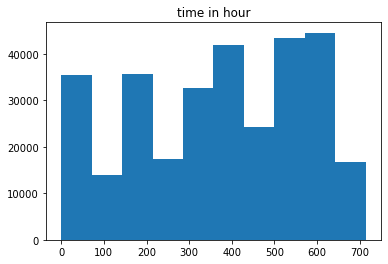

In [25]:
# distribution of numerical values seem better now
transcript.hist(grid=False)
plt.title('time in hour');

Inconsistency of unit between portfolio duration and transcript test time, will transform time in hour to day.

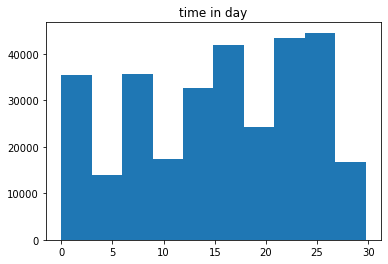

In [26]:
# convert transcript test time from hour to day
transcript['time_day'] = transcript['time']/24

# visualize again
transcript['time_day'].hist(grid=False)
plt.title('time in day')

# drop original column
transcript = transcript.drop('time', axis=1);

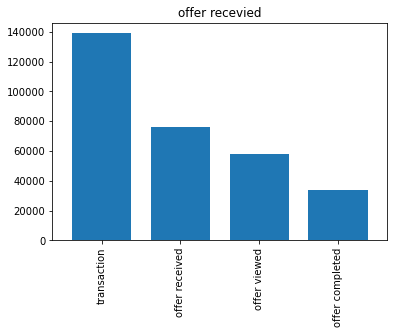

In [27]:
# look at event
transcript['event'].value_counts().plot(kind='bar', title='offer recevied', width=0.75);

In [28]:
def clean_value_col():
    """split value column of transcript into 3 columns amount, offer_id, reward
    
    Inputs: none
    Outputs: 3 new columns as a new dataset, dataframe
    """
    # split value column
    values = pd.json_normalize(transcript['value'])
    
    # get not null values in offer_id
    values_offer_id = values[values['offer id'].isnull()==False]
    
    # fill with original index
    filled_offers = values_offer_id.assign(offer_id=values_offer_id['offer id'])
    values_old = values.drop(values_offer_id.index, axis=0)
    values_new = values_old.append(filled_offers)
    values_new = values_new.drop(['offer id'], axis=1)
    
    return values_new

values_new = clean_value_col()

reference: https://stackoverflow.com/questions/38231591/split-explode-a-column-of-dictionaries-into-separate-columns-with-pandas

In [29]:
# merge new values columns back to transcript
transcript = transcript.merge(values_new, how='inner', left_index=True, right_index=True)
transcript = transcript.drop(['value'], axis=1)

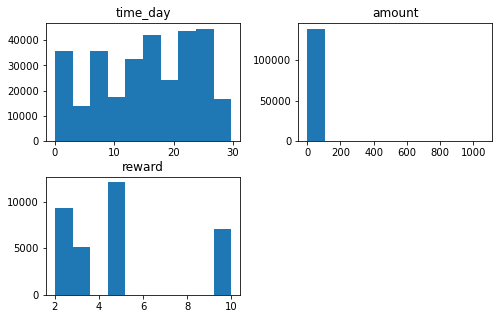

In [30]:
# look at distribution of numeric features in transcript
transcript.hist(figsize=(8,5), grid=False);

count    138953.000000
mean         12.777356
std          30.250529
min           0.050000
25%           2.780000
50%           8.890000
75%          18.070000
max        1062.280000
Name: amount, dtype: float64

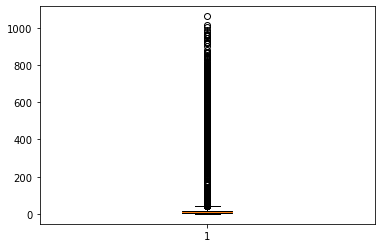

In [31]:
# as amount in previous plot is too squeezy, look at it seperately
plt.boxplot(transcript[transcript['amount'].isnull()==False]['amount'])
transcript[transcript['amount'].isnull()==False]['amount'].describe()

In [32]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   person    306534 non-null  object 
 1   event     306534 non-null  object 
 2   time_day  306534 non-null  float64
 3   amount    138953 non-null  float64
 4   offer_id  167581 non-null  object 
 5   reward    33579 non-null   float64
dtypes: float64(3), object(3)
memory usage: 16.4+ MB


amount has a huge range from 1062 to 0.05, with average as 12.7.

In [33]:
# rename person to customer id
transcript.rename(columns={'person':'customer_id'}, inplace=True)

In [34]:
# look at 1 customer and his orders to understand the original dataset
transcript[transcript['customer_id']=='78afa995795e4d85b5d9ceeca43f5fef']

,customer_id,event,time_day,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.00,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,0.25,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,5.50,19.89,NaN,NaN
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,5.50,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,6.00,17.78,NaN,NaN
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,7.00,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,9.00,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,9.25,19.67,NaN,NaN
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,10.00,29.72,NaN,NaN
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,15.75,23.93,NaN,NaN


Above we are using one customer as example to understand the dataset, it seems, for one customer, an effective offer is: <br>
- **offer_received -> offer_viewed -> if transaction over offer difficultiy -> offer_completed** <br>

Sometimes even an offer is not viewed, it can be completed, this is unintentional offer completed, therefore, we will try identify the effective offers first. <br>
As transaction here is used to measure if the offer is completed or not, will drop this feature from here.

In [35]:
def transcript_cleaning():
    """Encode categorical column (event) of transcript dataset
    
    Inputs: none
    Outputs: new transcript dataset, dataframe
    """
    events = pd.get_dummies(transcript['event'])
    transcript_new_df = transcript.merge(events, left_index=True, right_index=True)
    transcript_new_df = transcript_new_df.drop('event', axis=1)
    
    return transcript_new_df

transcript_new = transcript_cleaning()

In [36]:
# how many offers per customer get
num_offer_person = transcript_new.groupby('customer_id')['offer_id'].nunique().mean()

print('Number of offers per customer is {:.1f}.'.format(num_offer_person))

Number of offers per customer is 3.7.


In [37]:
# based on previous observation about effective offers, construct a dataset on effective offers

def df_effective_offer():
    """ construct a dataset of effective offer, per customer per offer id, 
        if offer is viewed and completed, that's an effective offer,
        if offer is only received or received and viewed, it's an ineffective offer
        
    Inputs: none
    Outputs: effective_offer dataset, dataframe
    
    """
    # group transcript df by events
    transcript_df = transcript_new.groupby(['customer_id','offer_id'], as_index=False).agg({'offer completed':'sum',
                                                                                        'offer received':'sum',
                                                                                        'offer viewed':'sum'})
    
    # construct a new column of effective offer
    transcript_df['effective_offer'] = transcript_df['offer completed'] + transcript_df['offer viewed']
    transcript_df['effective_offer'] = transcript_df['effective_offer'].apply(lambda x: 1 if x>=2 else 0)
    
    # drop columns offer_completed, offer_received, offer_viewed
    effective_offer = transcript_df.drop(['offer completed','offer received', 'offer viewed'], axis=1)
    
    return effective_offer

effective_offer_df = df_effective_offer()

In [38]:
# validate constructed dataset
effective_offer_df.isnull().sum()

customer_id        0
offer_id           0
effective_offer    0
dtype: int64

In [39]:
effective_offer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63288 entries, 0 to 63287
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   customer_id      63288 non-null  object
 1   offer_id         63288 non-null  object
 2   effective_offer  63288 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.9+ MB


### 4. merge datasets

In [40]:
def merge_df(df1=transcript, df2=profile, df3=portfolio):
    """Method to merge 2 dataframes on left, default is merging original dataframes
    
    Inputs: 
            df1: transcript dataframe
            df2: profile dataframe
            df3: portfolio dataframe
    
    Outputs:
            merged dataframe
    """
    df = df1.merge(df2, how='left', on='customer_id').merge(df3, how='left', on='offer_id')
    #df_new = df.drop(['id_x', 'id_y'], axis=1)
    
    return df

original_df = merge_df()
model_df = merge_df(df1=effective_offer_df, df2=profile_new, df3=portfolio_new)

In [41]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   customer_id             306534 non-null  object  
 1   event                   306534 non-null  object  
 2   time_day                306534 non-null  float64 
 3   amount                  138953 non-null  float64 
 4   offer_id                167581 non-null  object  
 5   reward_x                33579 non-null   float64 
 6   gender                  272430 non-null  object  
 7   age                     272430 non-null  float64 
 8   became_member_on        272430 non-null  float64 
 9   income                  272430 non-null  float64 
 10  became_member_on_year   272430 non-null  float64 
 11  became_member_on_month  272430 non-null  float64 
 12  became_member_on_day    272430 non-null  float64 
 13  age_group               271063 non-null  category
 14  rewa

In [44]:
# clean up original dataframe
original_df = original_df.drop('reward_y', axis=1)
original_df.rename(columns={'reward_x':'reward'}, inplace=True)

In [47]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   customer_id             306534 non-null  object  
 1   event                   306534 non-null  object  
 2   time_day                306534 non-null  float64 
 3   amount                  138953 non-null  float64 
 4   offer_id                167581 non-null  object  
 5   reward                  33579 non-null   float64 
 6   gender                  272430 non-null  object  
 7   age                     272430 non-null  float64 
 8   became_member_on        272430 non-null  float64 
 9   income                  272430 non-null  float64 
 10  became_member_on_year   272430 non-null  float64 
 11  became_member_on_month  272430 non-null  float64 
 12  became_member_on_day    272430 non-null  float64 
 13  age_group               271063 non-null  category
 14  chan

In [45]:
# clean up model dataframe
# it seems not all customer_id are in profile dataset
not_eo_df = profile[profile['customer_id'].isin(effective_offer_df['customer_id']) == False].shape[0]

not_profile_df = effective_offer_df[effective_offer_df['customer_id'].isin( \
    profile['customer_id']) == False]['customer_id'].shape[0]

print('{} exists in profile but not in effective_offer_df,\
 {} exists in effective_offer_df but not in profile df.'.format(not_eo_df, not_profile_df))

# drop customers not with features
model_df = model_df.dropna(axis=0)

5 exists in profile but not in effective_offer_df, 8125 exists in effective_offer_df but not in profile df.


In [46]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55163 entries, 0 to 63287
Data columns (total 67 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customer_id                 55163 non-null  object 
 1   offer_id                    55163 non-null  object 
 2   effective_offer             55163 non-null  int64  
 3   18_42                       55163 non-null  float64
 4   42_55                       55163 non-null  float64
 5   55_66                       55163 non-null  float64
 6   66_99                       55163 non-null  float64
 7   F                           55163 non-null  float64
 8   M                           55163 non-null  float64
 9   O                           55163 non-null  float64
 10  income                      55163 non-null  float64
 11  became_member_on_year_2013  55163 non-null  float64
 12  became_member_on_year_2014  55163 non-null  float64
 13  became_member_on_year_2015  551

### 5. Insights
In order to get some basic insights from the dataset, I will take a look at it from 2 aspects:
- Customer
- Offer

- Which offer type is the most difficult? Which reward the most?

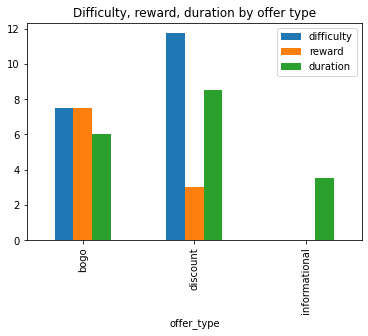

In [48]:
# set data
by_offer_type = portfolio.groupby(['offer_type'])[['difficulty','reward','duration']].mean()

# visualize
by_offer_type.plot(kind='bar')
plt.title('Difficulty, reward, duration by offer type');

Completion of discount is the most difficult, which also has the most duration and small rewards.

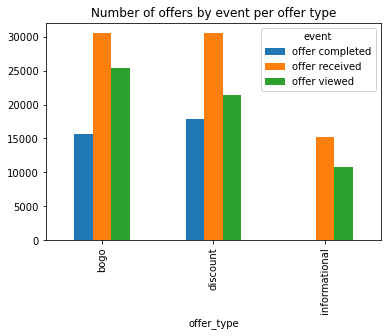

In [52]:
# look at number of offers by event type
original_df.groupby(['offer_type','event'])['offer_id'].count().unstack().plot(kind='bar')
plt.title('Number of offers by event per offer type');

In terms of offers, no completed offer for informational events (no track of that?), offer received is equal for discount and bogo (both around 30000), for offer viewed, discount (around 22000) is lower than bogo (around 25000), while for offer completed, it's ( around 18000) higher than bogo (around 15000). Looks discount could be the most effective event type with a higher completion rate, to be validated.

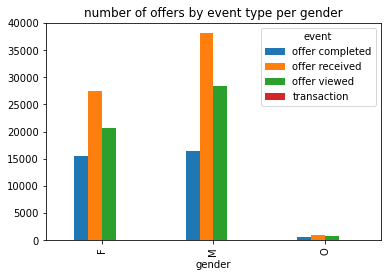

In [51]:
# gender with offer types
original_df.groupby(['gender','event'])['offer_id'].count().unstack().plot(kind='bar')
plt.title('number of offers by event type per gender');

It seems the pattern between female and male are the same for offer received, offer reviewed and offer completed. In terms of customer group, more males received/reviewed offers. However, it seems female is higher in ratio of offer viewed and offer completed.

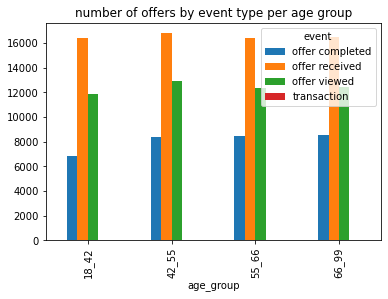

In [55]:
original_df.groupby(['age_group','event'])['offer_id'].count().unstack().plot(kind='bar')
plt.title('number of offers by event type per age group');

In [56]:
# effective offer rate
effective_perc = model_df['effective_offer'].mean()
print('In all offers, {}% is effective.'.format(effective_perc*100))

In all offers, 47.45390932327828% is effective.


Number of effective offers per customer is 0.49


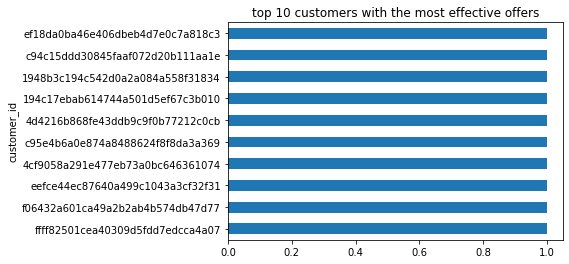

In [57]:
# effective offer by customers
top_customer_offer = model_df.groupby('customer_id')['effective_offer'].mean().sort_values(ascending=False)
top_customer_offer.head(10).plot(kind='barh', title='top 10 customers with the most effective offers')
print('Number of effective offers per customer is {:.2f}'.format(top_customer_offer.mean()))

For top 10 customers, they can complete their offers that they received.

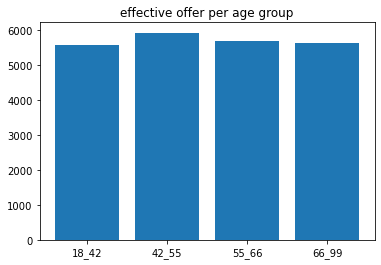

In [58]:
# number of effective offers per age group
effective_offer = model_df[model_df['effective_offer']==1]
age_1 = (effective_offer['18_42']==1).sum()
age_2 = (effective_offer['42_55']==1).sum()
age_3 = (effective_offer['55_66']==1).sum()
age_4 = (effective_offer['66_99']==1).sum()

y = [age_1, age_2, age_3, age_4]
x = range(0, 4)
plt.bar(x, y)
plt.xticks(x, labels=['18_42','42_55','55_66','66_99'])
plt.title('effective offer per age group');

In [66]:
def effective_offer_by_feature(selected_features):
    """Method to visualize multiple comparable columns and their number of average effective offers
    
    Inputs: selected features, list of column names
    Outputs: none
    """
    # construct effective offer dataframe
    effective_offer = model_df[model_df['effective_offer']==1]
    
    # initialize
    features_values = []
    count = 0
    features_names = []
    
    # loop to get list of feature names and feature of values
    for col in selected_features:
        feature_value = (effective_offer[col]==1).sum()/effective_offer_df.shape[0]
        features_values.append(feature_value)
        features_names.append(col)
        count+=1
    feature_mean = np.array(features_values).mean()
    
    # construct y and x in plot
    y = features_values - feature_mean
    x = range(0, count)
    
    # differentiate by color for values below and above averages
    cc=list(map(lambda x: 'red' if x <= 0 else 'green', y))
    
    # visualize
    plt.bar(x, y, color=cc)
    plt.annotate('mean: {:.2f}'.format(feature_mean), xy=(0.02, 0.94), xycoords='axes fraction')
    plt.xticks(x, features_names, rotation=90)
    plt.title('effective offer compared with mean per feature group')

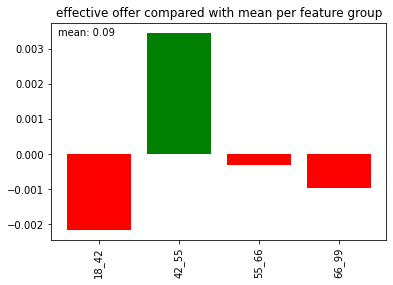

In [72]:
# age group
age_group = model_df.columns[3:7]
effective_offer_by_feature(age_group)

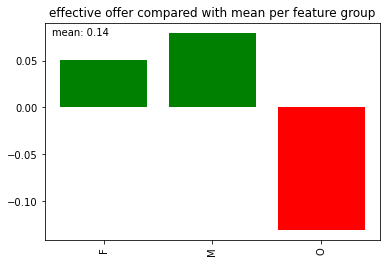

In [76]:
# gender group
gender_group = model_df.columns[7:10]
effective_offer_by_feature(gender_group)

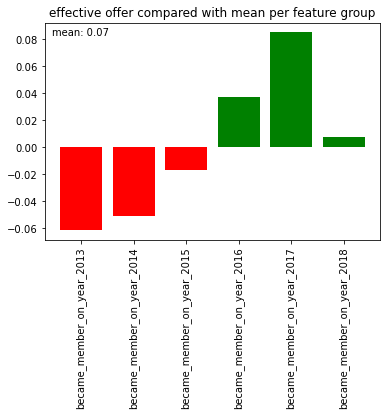

In [77]:
# became_member_on_year group
year_group = model_df.columns[11:17]
effective_offer_by_feature(year_group)

In [79]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55163 entries, 0 to 63287
Data columns (total 67 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customer_id                 55163 non-null  object 
 1   offer_id                    55163 non-null  object 
 2   effective_offer             55163 non-null  int64  
 3   18_42                       55163 non-null  float64
 4   42_55                       55163 non-null  float64
 5   55_66                       55163 non-null  float64
 6   66_99                       55163 non-null  float64
 7   F                           55163 non-null  float64
 8   M                           55163 non-null  float64
 9   O                           55163 non-null  float64
 10  income                      55163 non-null  float64
 11  became_member_on_year_2013  55163 non-null  float64
 12  became_member_on_year_2014  55163 non-null  float64
 13  became_member_on_year_2015  551

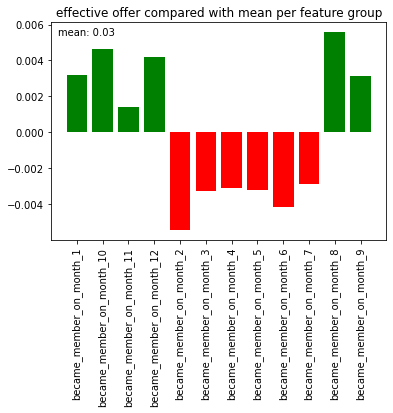

In [80]:
# became_member_on_month group
month_group = model_df.columns[17:29]
effective_offer_by_feature(month_group)

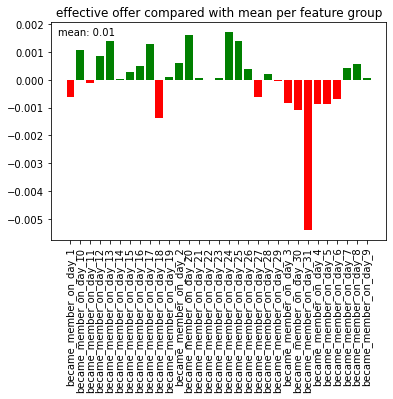

In [81]:
# became_member_on_month group
day_group = model_df.columns[29:60]
effective_offer_by_feature(day_group)

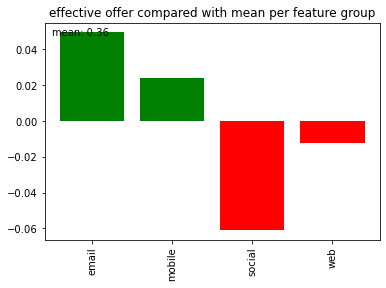

In [82]:
# channel group
channel_group = model_df.columns[63:67]
effective_offer_by_feature(channel_group)

In [84]:
model_df.columns

Index(['customer_id', 'offer_id', 'effective_offer', '18_42', '42_55', '55_66',
       '66_99', 'F', 'M', 'O', 'income', 'became_member_on_year_2013',
       'became_member_on_year_2014', 'became_member_on_year_2015',
       'became_member_on_year_2016', 'became_member_on_year_2017',
       'became_member_on_year_2018', 'became_member_on_month_1',
       'became_member_on_month_10', 'became_member_on_month_11',
       'became_member_on_month_12', 'became_member_on_month_2',
       'became_member_on_month_3', 'became_member_on_month_4',
       'became_member_on_month_5', 'became_member_on_month_6',
       'became_member_on_month_7', 'became_member_on_month_8',
       'became_member_on_month_9', 'became_member_on_day_1',
       'became_member_on_day_10', 'became_member_on_day_11',
       'became_member_on_day_12', 'became_member_on_day_13',
       'became_member_on_day_14', 'became_member_on_day_15',
       'became_member_on_day_16', 'became_member_on_day_17',
       'became_member_on_da

In [89]:
model_df[num_group].corr()

,effective_offer,income,reward,difficulty,duration
effective_offer,1.000000,0.127819,0.184785,0.132435,0.207399
income,0.127819,1.000000,-0.000383,-0.000734,-0.001044
reward,0.184785,-0.000383,1.000000,0.465215,0.160815
difficulty,0.132435,-0.000734,0.465215,1.000000,0.808828
duration,0.207399,-0.001044,0.160815,0.808828,1.000000


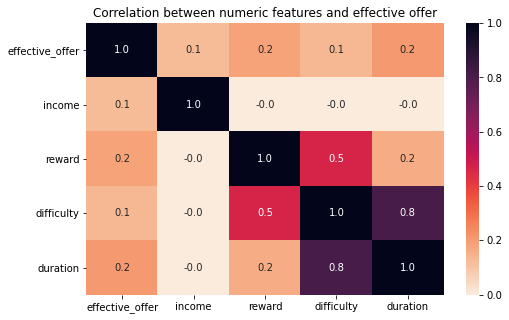

In [93]:
# numeric group
num_group = ['effective_offer', 'income', 'reward', 'difficulty', 'duration']
plt.figure(figsize=(8,5))
sb.heatmap(model_df[num_group].corr(), cmap='rocket_r', annot=True, fmt='.1f')
plt.title('Correlation between numeric features and effective offer');

### Preparing data set - profile

- Which feature is the most important to completing an offer?

In [96]:
# drop offer id and customer id in model dataset
df = model_df.drop(['customer_id','offer_id'], axis=1)

In [98]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.metrics import precision_recall_fscore_support as score

In [99]:
X = df.drop('effective_offer', axis=1)
y = df[['effective_offer']]

In [100]:
# creat traing, test sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Try different models

### Random forest classifier

In [101]:
# although scaling is not needed in ensemble, but it's used to speed up the process
pipeline_rfc = Pipeline([
    ('scaler', StandardScaler()),
    ('rfc', RandomForestClassifier())
])

# fit model
pipeline_rfc.fit(X_train, y_train)
y_pred_rfc = pipeline_rfc.predict(X_test)

In [102]:
def display_results(y_pred, y_test):
    """Method to iterate classification report per target and overall accuracy
    
    Args:
    y_pred: panda series
    y_test: panda series
    
    Returns:
    None
    """
    # calculated overall accuracy
    print('Overall accuracy of current model is {:.3f}'.format(accuracy_score(y_test, y_pred)))
    
    # classification report per column
    col_name = 'effective_offer'
    
    results = classification_report(y_test, y_pred)
    print('Feature:', 'effective offer', '\n', results)

In [103]:
display_results(y_pred_rfc, y_test)

Overall accuracy of current model is 0.717
Feature: effective offer 
               precision    recall  f1-score   support

           0       0.73      0.74      0.73      7220
           1       0.71      0.69      0.70      6571

    accuracy                           0.72     13791
   macro avg       0.72      0.72      0.72     13791
weighted avg       0.72      0.72      0.72     13791



In [105]:

precision,recall,fscore,support=score(y_true,y_pred,average='macro')
print 'Precision : {}'.format(precision)
print 'Recall    : {}'.format(recall)
print 'F-score   : {}'.format(fscore)
print 'Support   : {}'.format(support)

' '

### SVC

In [ ]:
svc_clf = svm.SVC()
svc_clf.fit(X_train, y_train)
y_pred_svc = svc_clf.predict(X_test)

In [ ]:
display_results(y_pred_svc, y_test)

### LogisticClassifier

In [ ]:
pipeline_lg = Pipeline([
    ('scaler', StandardScaler()),
    ('lg',LogisticRegression())
])
pipeline_lg.fit(X_train, y_train)
y_pred_lg = pipeline_lg.predict(X_test)

In [ ]:
display_results(y_pred_lg, y_test)

### AdaboostClassifier

In [ ]:
pipeline_adb = Pipeline([
    ('scaler', StandardScaler()),
    ('adb', AdaBoostClassifier())
])

pipeline_adb.fit(X_train, y_train)
y_pred_adb = pipeline_adb.predict(X_test)

In [ ]:
display_results(y_pred_adb, y_test)

### Tuning parameters

In [ ]:
# use the best parameters
pipeline_adb = Pipeline([
    ('scaler', StandardScaler()),
    ('adb', AdaBoostClassifier(learning_rate=1, 
                      n_estimators=100))
])

pipeline_adb.fit(X_train, y_train)
y_pred_adb = pipeline_adb.predict(X_test)
display_results(y_pred_adb, y_test)

In [ ]:
# create other features
from sklearn.feature_selection import SelectPercentile, f_classif

In [ ]:
pipeline_adb_= Pipeline([
    ('scaler', StandardScaler()),
    ('features_select', SelectPercentile(f_classif, percentile=10)),
    ('adb', AdaBoostClassifier(learning_rate=1, 
                      n_estimators=100))
])

pipeline_adb.fit(X_train, y_train)
y_pred_adb = pipeline_adb.predict(X_test)
display_results(y_pred_adb, y_test)

In [ ]:
y_train_adb = pipeline_adb.predict(X_train)
display_results(y_train_adb, y_train)

#### boosting ML doesn't need to be scaled with features, but scaling can speed up ML model
https://towardsdatascience.com/the-ultimate-guide-to-adaboost-random-forests-and-xgboost-7f9327061c4f#:~:text=Compared%20to%20random%20forests%20and,being%20significantly%20slower%20than%20XGBoost.

#### Try adaboost without feature scaling

In [ ]:
# try without scaling
pipeline_adb_= Pipeline([
    ('features_select', SelectPercentile(f_classif, percentile=10)),
    ('adb', AdaBoostClassifier(learning_rate=1, 
                      n_estimators=100))
])

pipeline_adb.fit(X_train, y_train)
y_pred_adb = pipeline_adb.predict(X_test)
display_results(y_pred_adb, y_test)